<a href="https://colab.research.google.com/github/jsleocadio/Artificial-Intelligence/blob/main/Image_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Source:** [Towards Data Science](https://towardsdatascience.com/introduction-to-image-classification-with-tensorflow-part-1-381d0a373b8f)<br>
**Author:** [Zolzaya Luvsandorj](https://zluvsand.github.io/)

[Computer Vision is an area of Artificial Intelligence that enables machines to process visual data such as images and video into meaningful information. Image classification is one popular application of computer vision](https://www.ibm.com/au-en/topics/computer-vision#:~:text=Computer%20vision%20is%20a%20field,recommendations%20based%20on%20that%20information.). In this post, we will learn how to do a basic image classification in Python with TensorFlow, an open source deep learning library developed by Google.
***

📦 Data<br>
We will use the MNIST dataset of handwritten digits, one of well-known introductory image datasets. [The data is available under the Creative Commons Attribution-Share Alike 3.0 licence.](https://keras.io/api/datasets/mnist/) We will load the necessary libraries and data:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Flatten, Dense,  
                                     Conv2D, MaxPooling2D)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
train_data, valid_data, train_labels, valid_labels =  train_test_split(
    train_data, train_labels, test_size=10000, random_state=42
)
print("========== Training data ==========")
print(f"Data shape: {train_data.shape}")
print(f"Label shape: {train_labels.shape}")
print(f"Unique labels: {np.unique(train_labels)}")
print("\n========== Validation data ==========")
print(f"Data shape: {valid_data.shape}")
print(f"Label shape: {valid_labels.shape}")
print(f"Unique labels: {np.unique(valid_labels)}")
print("\n========== Test data ==========")
print(f"Data shape: {test_data.shape}")
print(f"Label shape: {test_labels.shape}")
print(f"Unique labels: {np.unique(test_labels)}")

11490434/11490434 [==============================] - 0s 0us/step
========== Training data ==========
Data shape: (50000, 28, 28)
Label shape: (50000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]

========== Validation data ==========
Data shape: (10000, 28, 28)
Label shape: (10000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]

========== Test data ==========
Data shape: (10000, 28, 28)
Label shape: (10000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


We have 50K training, 10K validation and 10K test 28-by-28-pixel images. As expected, there are 10 classes of digits. Let’s now check the class distribution for each partitioned datasets:

In [2]:
n_classes = len(np.unique(train_labels))
(pd.concat([pd.Series(train_labels).value_counts(normalize=True)
              .sort_index(),
            pd.Series(valid_labels).value_counts(normalize=True)
              .sort_index(),
            pd.Series(test_labels).value_counts(normalize=True)
              .sort_index()], 
           keys=['train', 'valid', 'test'], axis=1)
   .style.background_gradient('YlGn', axis='index').format("{:.2%}"))

,train,valid,test
0,9.88%,9.84%,9.80%
1,11.30%,10.93%,11.35%
2,9.93%,9.94%,10.32%
3,10.26%,10.00%,10.10%
4,9.72%,9.80%,9.82%
5,9.00%,9.19%,8.92%
6,9.87%,9.81%,9.58%
7,10.41%,10.60%,10.28%
8,9.74%,9.79%,9.74%
9,9.88%,10.10%,10.09%


The class distribution is quite balanced across datasets. If you want to learn how to prettify your pandas DataFrame like this, you may find [this post](https://towardsdatascience.com/prettifying-pandas-dataframes-75c1a1a6877d) useful.

Before we start building image classification models, let’s explore the data by inspecting a few sample images:

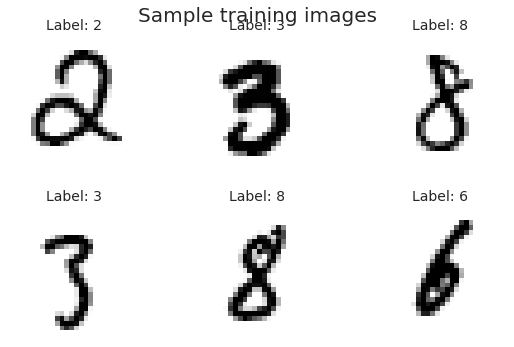

In [3]:
def inspect_sample_images(data, labels, title, n_rows=2, n_cols=3, 
                          seed=42):
    np.random.seed(seed)
    indices = np.random.choice(range(len(data)), n_rows*n_cols, 
                               replace=False)
    plt.figure(figsize=(8,5))
    for i, ind in enumerate(indices):
        ax = plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(data[ind], cmap='binary')
        plt.axis('off')
        plt.title(f"Label: {labels[ind]}", fontsize=14)
    plt.suptitle(title, fontsize=20)
    plt.tight_layout();
    
inspect_sample_images(train_data, train_labels, 'Sample training images')

We can see that the images reflect different handwriting.

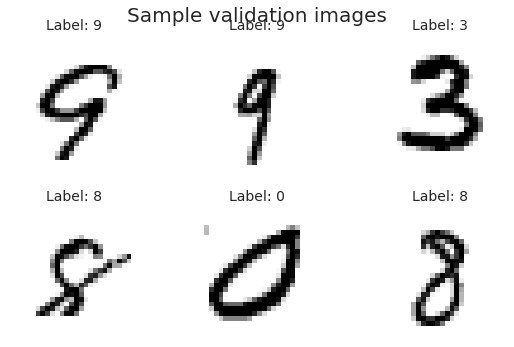

In [4]:
inspect_sample_images(valid_data, valid_labels, 'Sample validation images')

Digit 8 at the bottom left is cut out slightly. Perhaps some images are possibly cropped.

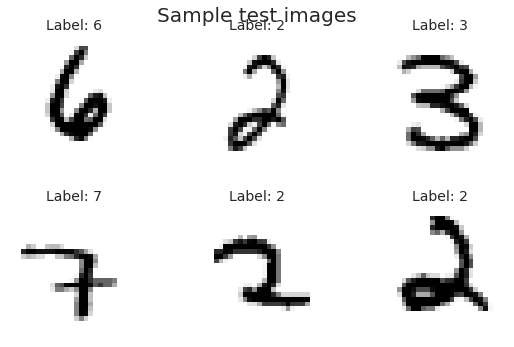

In [5]:
inspect_sample_images(test_data, test_labels, 'Sample test images')

There are a couple of 2s in this sample and they each have their own style.
***

🔨 Modelling<br>
This is the exciting part! Since the model building process is very experimental and iterative, we will iteratively build a couple of models.

🔧 Model 0<br>
Currently, the labels are in 1D array format. We need to one-hot-encode our labels like this:

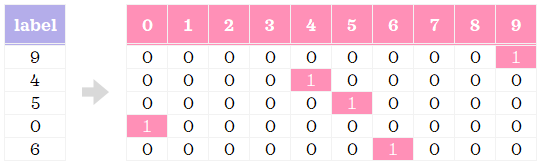

Now, let’s build our first simple neural network. We will set seed for reproducibility.

In [6]:
train_labels_ohe = tf.one_hot(train_labels, 10)
valid_labels_ohe = tf.one_hot(valid_labels, 10)
test_labels_ohe = tf.one_hot(test_labels, 10)
tf.random.set_seed(42)
model_0 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(16, activation="relu"),
    Dense(16, activation="relu"),
    Dense(n_classes, activation="softmax")
])
model_0.compile(loss="categorical_crossentropy", optimizer='Adam',
                metrics=["accuracy"])
model_0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


Here we first defined the architecture of the neural network, then compiled it and printed its summary. Let’s look more closely.

◼️ Defined the architecture of the neural network
In the first layer (flatten), it flattens the images from (28, 28) 2D array to (784) 1D array. Then, we have two fully connected hidden layers (dense & dense_1). For these layers, we used ReLu activation function. This is followed by the output layer with softmax activation function (dense_2) that has the same number of units as the number of classes.

◼ Compiled the model
We used categorical_crossentropy loss function. This loss function and softmax activation function in the output layer allows us to get probabilities for each class since we are building a multi-class classification model. We have used Adam optimiser.

◼ Printed the model summary
Once compiled, we can see model’s layers as well as the number of parameters from the summary.

Now, it’s time to train the network:

In [7]:
hist_0 = model_0.fit(train_data, train_labels_ohe, epochs=5, 
                     validation_data=(valid_data, valid_labels_ohe))

Epoch 1/5
1563/1563 [==============================] - 5s 2ms/step - loss: 2.2112 - accuracy: 0.3357 - val_loss: 1.2387 - val_accuracy: 0.5517
Epoch 2/5
1563/1563 [==============================] - 4s 2ms/step - loss: 1.0580 - accuracy: 0.5973 - val_loss: 0.9432 - val_accuracy: 0.6374
Epoch 3/5
1563/1563 [==============================] - 4s 2ms/step - loss: 0.8405 - accuracy: 0.6922 - val_loss: 0.7166 - val_accuracy: 0.7401
Epoch 4/5
1563/1563 [==============================] - 4s 2ms/step - loss: 0.6893 - accuracy: 0.7605 - val_loss: 0.6581 - val_accuracy: 0.7691
Epoch 5/5
1563/1563 [==============================] - 4s 2ms/step - loss: 0.6241 - accuracy: 0.7823 - val_loss: 0.5922 - val_accuracy: 0.7896


We will do only 5 epochs for faster training. This means the network will go through the data 5 times. From the summary above, we see that the accuracy is improving with each epoch. Let’s visualise the accuracy over epochs:

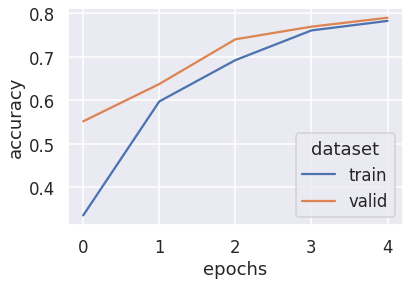

In [10]:
def clean_history(hist):
    epochs = len(hist.history['accuracy'])
    df = pd.DataFrame(
        {'epochs': np.tile(np.arange(epochs), 2),
         'accuracy': hist.history['accuracy'] + 
                     hist.history['val_accuracy'], 
         'loss': hist.history['loss'] + 
                 hist.history['val_loss'], 
         'dataset': np.repeat(['train', 'valid'], epochs)}
    )
    return df
sns.lineplot(data=clean_history(hist_0), x='epochs', y='accuracy', 
             hue='dataset');

We have created a function since this will be useful for evaluating subsequent models. We will continue to build functions for other evaluation methods. Let’s evaluate the model’s performance on unseen test data:

In [11]:
test_preds_0 = model_0.predict(test_data)
test_classes_0 = test_preds_0.argmax(axis=1)
test_metrics = pd.DataFrame(columns=['Test accuracy'])
test_metrics.loc['model_0'] = np.mean(test_labels==test_classes_0)
test_metrics

313/313 [==============================] - 1s 1ms/step


,Test accuracy
model_0,0.7965


Cool, we will add performance of subsequent models to this DataFrame so that we can see all at once. `test_preds_0` consists of (10000, 10) 2D array containing predicted probabilities by class for each record. We then assigned the class with the highest probability for each record and saved it into `test_classes_0`. Now, let’s look at confusion matrix:

In [12]:
def show_confusion_matrix(labels, classes):
    cm = (pd.crosstab(pd.Series(labels, name='actual'), 
                      pd.Series(classes, name='predicted'))
            .style.background_gradient('binary'))
    return cm
show_confusion_matrix(test_labels, test_classes_0)

predicted,0,1,2,3,4,5,6,7,8,9
actual,,,,,,,,,,
0,939,0,11,0,1,5,9,5,7,3
1,0,1098,10,1,1,4,1,0,18,2
2,9,1,852,0,12,17,47,9,79,6
3,6,0,45,791,1,129,2,5,6,25
4,0,0,11,0,911,4,11,6,5,34
5,12,1,47,70,9,710,9,7,22,5
6,15,1,7,0,9,16,891,0,19,0
7,4,2,26,0,13,5,0,781,20,177
8,8,8,726,0,10,31,35,9,118,29


It’s great to see that the majority of the records are along the diagonal stretching from top left to bottom right. Interestingly, the current model mistakes 8s with 2s quite often.

Let’s inspect a few example images with their predictions:

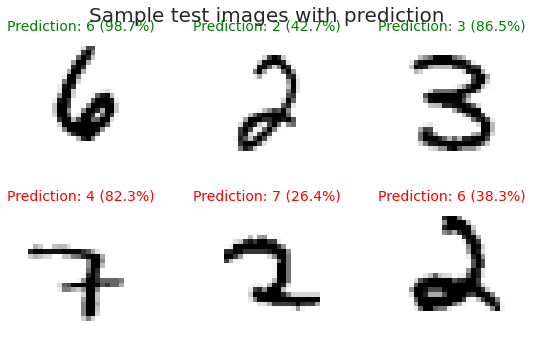

In [13]:
def inspect_sample_predictions(data, labels, preds, dataset='test', 
                               seed=42, n_rows=2, n_cols=3):
    np.random.seed(seed)
    indices = np.random.choice(range(len(data)), n_rows*n_cols, 
                               replace=False)
    plt.figure(figsize=(8,5))
    for i, ind in enumerate(indices):
        ax = plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(data[ind], cmap='binary')
        plt.axis('off')
        proba = preds[ind].max()
        pred = preds[ind].argmax()
        if pred == labels[ind]:
            colour = 'green'
        else:
            colour = 'red'
        plt.title(f"Prediction: {pred} ({proba:.1%})", fontsize=14, 
                  color=colour)
    plt.suptitle(f'Sample {dataset} images with prediction', 
                 fontsize=20)
    plt.tight_layout();
    
inspect_sample_predictions(test_data, test_labels, test_preds_0)

We will now look at the most incorrect predictions (i.e. incorrect predictions with the highest probability):

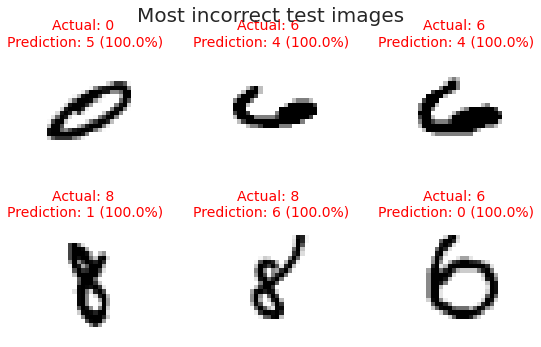

In [14]:
def see_most_incorrect(data, labels, preds, dataset='test', seed=42, 
                       n_rows=2, n_cols=3):
    df = pd.DataFrame()
    df['true_class'] = labels
    df['pred_class'] = preds.argmax(axis=1)
    df['proba'] = preds.max(axis=1)
    
    incorrect_df = df.query("true_class!=pred_class")\
                     .nlargest(n_rows*n_cols, 'proba')
    
    plt.figure(figsize=(8,5))
    for i, (ind, row) in enumerate(incorrect_df.iterrows()):
        ax = plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(data[ind], cmap='binary')
        plt.axis('off')
        true = int(row['true_class'])
        proba = row['proba']
        pred = int(row['pred_class'])
    
        plt.title(f"Actual: {true} \nPrediction: {pred} ({proba:.1%})", 
                  fontsize=14, color='red')
    plt.suptitle(f'Most incorrect {dataset} images', fontsize=20)
    plt.tight_layout();
    
see_most_incorrect(test_data, test_labels, test_preds_0)

As we are rounding to one decimal when printing the probabilities, 100.0% here most likely represents probabilities like 99.95..% or 99.99..%. This gives us a glimpse of the kind of images that the model is confidently getting wrong. Even for humans, the first and last images are bit tricky to identify as 6.

Let’s see if we can improve the model.

🔧 Model 1<br>
Neural networks tend to work well with data that’s squished between 0 and 1. So we will rescale the data to this range using the following formula:

$$x_{i\_scaled} = \frac{x_i - min(x)}{max(x) - min(x)}$$

Since the pixel values range between 0 (min) and 255 (max), we just need to divide values by 255 to scale. Besides rescaling, we will keep everything else the same as before. It’s good practice to change one thing at a time and understand its impact:

In [15]:
train_data_norm = train_data/255
valid_data_norm = valid_data/255
test_data_norm = test_data/255
tf.random.set_seed(42)
model_1 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(16, activation="relu"),
    Dense(16, activation="relu"),
    Dense(n_classes, activation="softmax")
])
model_1.compile(loss="categorical_crossentropy", optimizer='Adam',
               metrics=["accuracy"])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                12560     
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 10)                170       
                                                                 
Total params: 13,002
Trainable params: 13,002
Non-trainable params: 0
_________________________________________________________________


Let’s train the compiled model on the rescaled data:

In [16]:
hist_1 = model_1.fit(
    train_data_norm, train_labels_ohe, epochs=5, 
    validation_data=(valid_data_norm, valid_labels_ohe)
)

Epoch 1/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.4550 - accuracy: 0.8657 - val_loss: 0.2854 - val_accuracy: 0.9153
Epoch 2/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2501 - accuracy: 0.9277 - val_loss: 0.2343 - val_accuracy: 0.9315
Epoch 3/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2163 - accuracy: 0.9379 - val_loss: 0.2056 - val_accuracy: 0.9407
Epoch 4/5
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1924 - accuracy: 0.9447 - val_loss: 0.1976 - val_accuracy: 0.9387
Epoch 5/5
1563/1563 [==============================] - 9s 6ms/step - loss: 0.1756 - accuracy: 0.9483 - val_loss: 0.1927 - val_accuracy: 0.9427


With a simple preprocessing step, the performance is much better than before! Now, let’s visualise the performance over epochs:

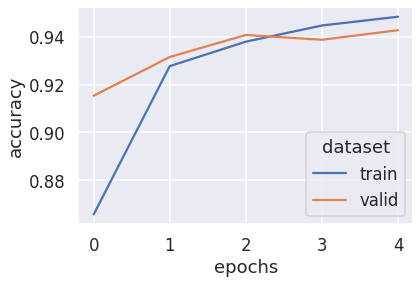

In [17]:
sns.lineplot(data=clean_history(hist_1), x='epochs', y='accuracy', 
             hue='dataset');

Time to evaluate the model on test data and add it to our `test_metrics` DataFrame.

In [18]:
test_preds_1 = model_1.predict(test_data_norm)
test_classes_1 = test_preds_1.argmax(axis=1)
test_metrics.loc['model_1'] = np.mean(test_labels==test_classes_1)
test_metrics

313/313 [==============================] - 1s 2ms/step


,Test accuracy
model_0,0.7965
model_1,0.9471


We improved the model’s predictive power quite substantially with one simple change. Let’s look at performance more closely with a confusion matrix:

In [19]:
show_confusion_matrix(test_labels, test_classes_1)

predicted,0,1,2,3,4,5,6,7,8,9
actual,,,,,,,,,,
0,971,0,1,0,1,3,1,1,2,0
1,0,1113,5,1,0,1,3,2,9,1
2,12,1,970,6,9,0,6,18,9,1
3,3,0,22,930,1,16,0,12,11,15
4,2,1,5,0,912,0,4,2,2,54
5,8,3,1,19,4,822,13,4,7,11
6,13,3,2,0,3,11,920,0,6,0
7,3,6,13,5,1,0,0,984,0,16
8,11,5,3,14,11,7,9,11,882,21


Now, 8s are no longer frequently confused with 2s. The most common mistake now is confusing 4s with 9s. This is not too surprising as they do look similar among some handwritings.

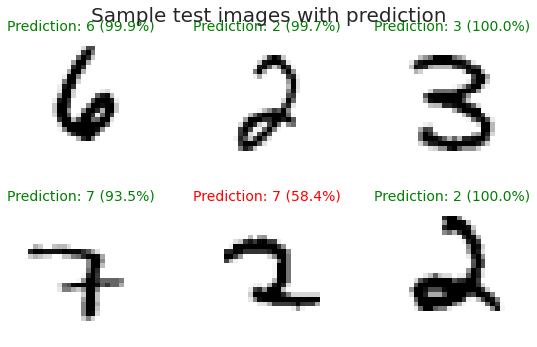

In [20]:
inspect_sample_predictions(test_data_norm, test_labels, 
                           test_preds_1)

As we used the same seed to pull random images, we are looking at the same subset of images as before. We can see that some of previously incorrectly predicted images are now correctly predicted. It’s good to see that correct images have high probability whereas the incorrect one has lower probability.

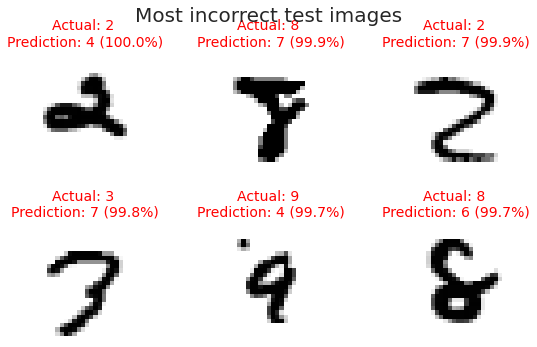

In [21]:
see_most_incorrect(test_data_norm, test_labels, test_preds_1)

We can see that there’s still room for improvement.

Let’s see if we can improve the model.

🔧 Model 2<br>
We will use `model_1` as the base and increase the number of units from 16 to 64 in the hidden layers:

In [22]:
tf.random.set_seed(42)
model_2 = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(n_classes, activation="softmax")
])
model_2.compile(loss="categorical_crossentropy", optimizer='Adam',
                metrics=["accuracy"])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


We have a lot more parameters now since we have increased the number of units.

In [23]:
hist_2 = model_2.fit(
    train_data_norm, train_labels_ohe, epochs=5, 
    validation_data=(valid_data_norm, valid_labels_ohe)
)

Epoch 1/5
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2947 - accuracy: 0.9130 - val_loss: 0.1638 - val_accuracy: 0.9502
Epoch 2/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1317 - accuracy: 0.9605 - val_loss: 0.1380 - val_accuracy: 0.9586
Epoch 3/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0971 - accuracy: 0.9710 - val_loss: 0.1017 - val_accuracy: 0.9702
Epoch 4/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0752 - accuracy: 0.9766 - val_loss: 0.1058 - val_accuracy: 0.9673
Epoch 5/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0645 - accuracy: 0.9798 - val_loss: 0.0879 - val_accuracy: 0.9732


The model performance looks slightly better than before.

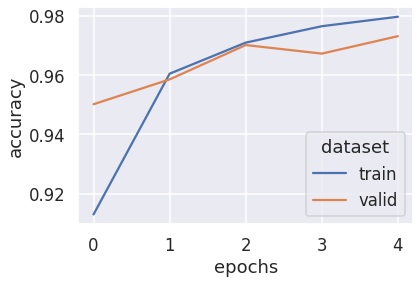

In [24]:
sns.lineplot(data=clean_history(hist_2), x='epochs', y='accuracy', 
             hue='dataset');

In the last two epochs, the model is slightly overfitting. Let’s evaluate the model on the test data:

In [25]:
test_preds_2 = model_2.predict(test_data_norm)
test_classes_2 = test_preds_2.argmax(axis=1)
test_metrics.loc['model_2'] = np.mean(test_labels==test_classes_2)
test_metrics

313/313 [==============================] - 1s 2ms/step


,Test accuracy
model_0,0.7965
model_1,0.9471
model_2,0.9719


Awesome, it’s great to see we are still seeing improvements to the model.

In [26]:
show_confusion_matrix(test_labels, test_classes_2)

predicted,0,1,2,3,4,5,6,7,8,9
actual,,,,,,,,,,
0,971,1,0,0,1,1,2,1,2,1
1,0,1122,7,2,0,1,1,0,2,0
2,5,1,1001,6,1,0,2,6,9,1
3,0,0,8,980,0,5,0,6,2,9
4,1,0,4,0,950,0,4,2,0,21
5,2,0,1,12,1,862,4,1,3,6
6,8,2,3,1,3,7,931,0,3,0
7,1,5,7,4,5,0,0,988,4,14
8,8,0,5,7,5,5,4,4,929,7


As the model is more accurate, the confusion matrix looks more concentrated along the diagonal with mostly light grey to white cells in the rest of the cells.

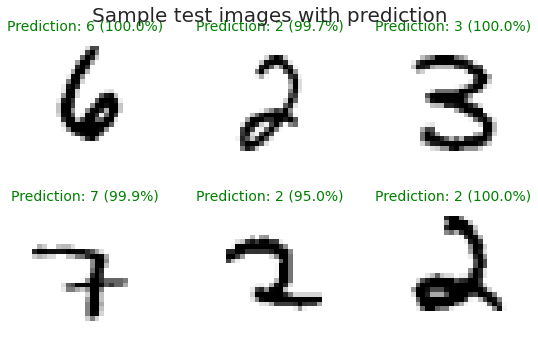

In [27]:
inspect_sample_predictions(test_data_norm, test_labels, 
                           test_preds_2)

Now, the model gets all the sample images right!

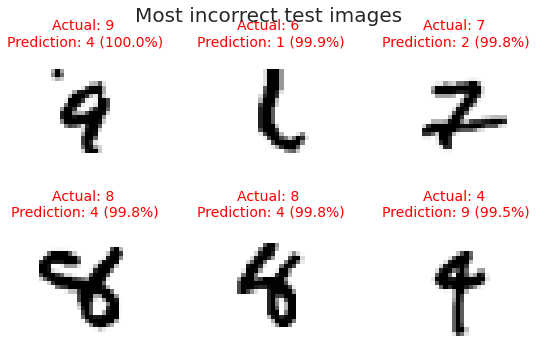

In [28]:
see_most_incorrect(test_data_norm, test_labels, test_preds_2)

The middle image at the top looks tricky while the rest of the images are relatively easier for humans to recognise.

Let’s see if we can improve the model one last time.

🔧 Model 3<br>
Convolutional Neural Network (CNN) works well with image data. So let’s now apply a simple CNN to our data.

In [29]:
model_3 = Sequential([
    Conv2D(32, 5, padding='same', activation='relu', 
           input_shape=(28,28,1)),
    Conv2D(32, 5, padding='same', activation='relu'),
    MaxPooling2D(), 
    Conv2D(32, 5, padding='same', activation='relu'),
    Conv2D(32, 5, padding='same', activation='relu'),
    MaxPooling2D(), 
    Flatten(),
    Dense(128, activation='relu'),
    Dense(n_classes, activation="softmax")
])
model_3.compile(loss="categorical_crossentropy", optimizer='Adam',
                metrics=["accuracy"])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

We have a lot more parameters now. Let’s train the model:

In [30]:
hist_3 = model_3.fit(
    train_data_norm, train_labels_ohe, epochs=5, 
    validation_data=(valid_data_norm, valid_labels_ohe)
)

Epoch 1/5
1563/1563 [==============================] - 416s 266ms/step - loss: 0.1219 - accuracy: 0.9620 - val_loss: 0.0550 - val_accuracy: 0.9840
Epoch 2/5
1563/1563 [==============================] - 410s 263ms/step - loss: 0.0422 - accuracy: 0.9869 - val_loss: 0.0534 - val_accuracy: 0.9858
Epoch 3/5
1563/1563 [==============================] - 412s 263ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0433 - val_accuracy: 0.9868
Epoch 4/5
1563/1563 [==============================] - 414s 265ms/step - loss: 0.0219 - accuracy: 0.9936 - val_loss: 0.0345 - val_accuracy: 0.9914
Epoch 5/5
1563/1563 [==============================] - 413s 264ms/step - loss: 0.0206 - accuracy: 0.9935 - val_loss: 0.0468 - val_accuracy: 0.9877


Awesome, there seem to be slight improvement to performance!

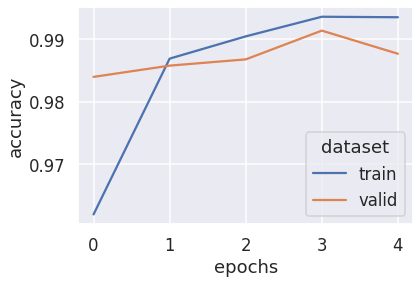

In [31]:
sns.lineplot(data=clean_history(hist_3), x='epochs', y='accuracy', 
             hue='dataset');

We can see that the model is very slightly overfitting.

In [32]:
test_preds_3 = model_3.predict(test_data_norm)
test_classes_3 = test_preds_3.argmax(axis=1)
test_metrics.loc['model_3'] = np.mean(test_labels==test_classes_3)
test_metrics

313/313 [==============================] - 18s 57ms/step


,Test accuracy
model_0,0.7965
model_1,0.9471
model_2,0.9719
model_3,0.9903


Woah, we have reached 99% accuracy! ✨

In [33]:
show_confusion_matrix(test_labels, test_classes_3)

predicted,0,1,2,3,4,5,6,7,8,9
actual,,,,,,,,,,
0,979,0,0,0,0,0,0,1,0,0
1,0,1135,0,0,0,0,0,0,0,0
2,0,2,1028,0,0,0,0,2,0,0
3,0,0,0,1003,0,3,0,1,1,2
4,0,0,0,0,979,0,0,0,0,3
5,3,0,0,5,0,866,1,1,3,13
6,8,4,0,0,5,2,936,0,3,0
7,0,6,2,0,5,0,0,1012,0,3
8,2,0,3,1,2,0,0,0,963,3


This is the best looking confusion matrix so far. We see many zeros off the diagonal and 1000+ along the diagonal for some digits.

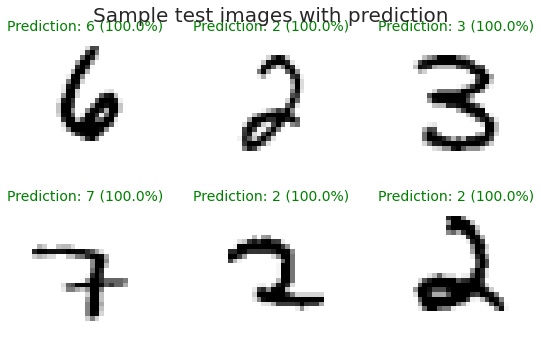

In [34]:
inspect_sample_predictions(test_data_norm, test_labels, 
                           test_preds_3)

Like before, sample images are predicted correctly.

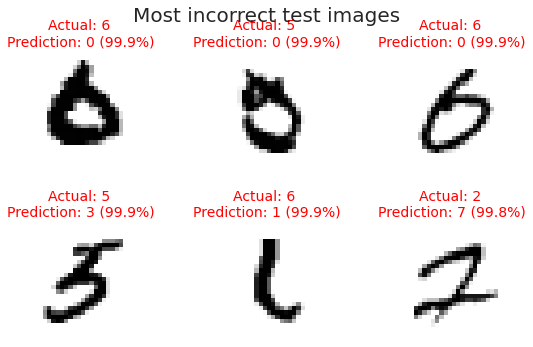

In [35]:
see_most_incorrect(test_data_norm, test_labels, test_preds_3)

Some of these images are a bit tricky, especially 6s and 7. One of these 6s seem to have also been identified as one of the most incorrect predictions by `model_2`.

We will end our model experimentation here in the interest of time. In practice, it’s almost certain that we will have to a whole lot more iterations before we settle to a model. In this post, we saw that each iteration improved our model predictive power. However, this is not always true in practice as some experiment ideas don’t work out. This is normal and just a nature of experimental approach.

While we explored only a couple of ideas as part of the four models, there are myriad of ways we could branch out the experimentation to improve the model. Here’re some ways one can try in an attempt to improve the model:<br>
◼️ Increase layers<br>
◼️ Change activation functions<br>
◼️ Train for longer (i.e. more epochs)

If you are working on well-known datasets, one way to get inspirations for your neural network design is to look at leading model architectures. For instance, we can see that leading models on MNIST dataset from [Papers with code](https://paperswithcode.com/sota/image-classification-on-mnist). At the time of writing this post, [Homogeneous ensemble with Simple CNN](https://paperswithcode.com/paper/an-ensemble-of-simple-convolutional-neural) is leading it with 99.91 accuracy. If you are curious, you can learn more about the model and its architecture from [the paper](https://arxiv.org/pdf/2008.10400v2.pdf). In addition, there is usually an [accompanying code](https://github.com/ansh941/MnistSimpleCNN) to dig further. Since most of leading models tend to have very strong performance, your options are not just limited to the top one model.
***